#                                             House price prediction
Practice project as per below link
https://github.com/ageron/handson-ml2/tree/master/datasets/housing

Dataset:
https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz

## Step 1

Collect the data and do basic ploting to get a hold of the data

In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
# fetch_housing_data()

In [5]:
import pandas as pd
import numpy as np

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

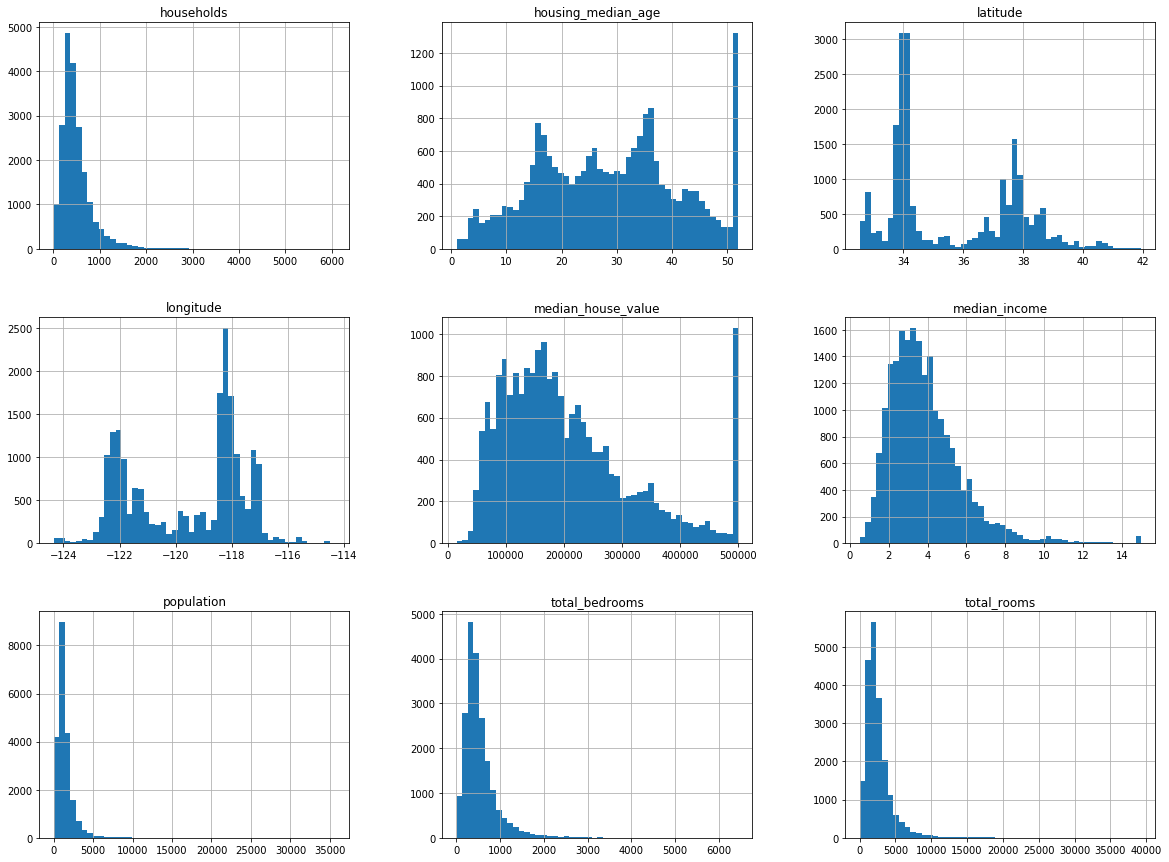

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

##### Using the correlation heatmap to visualize features and target correlation

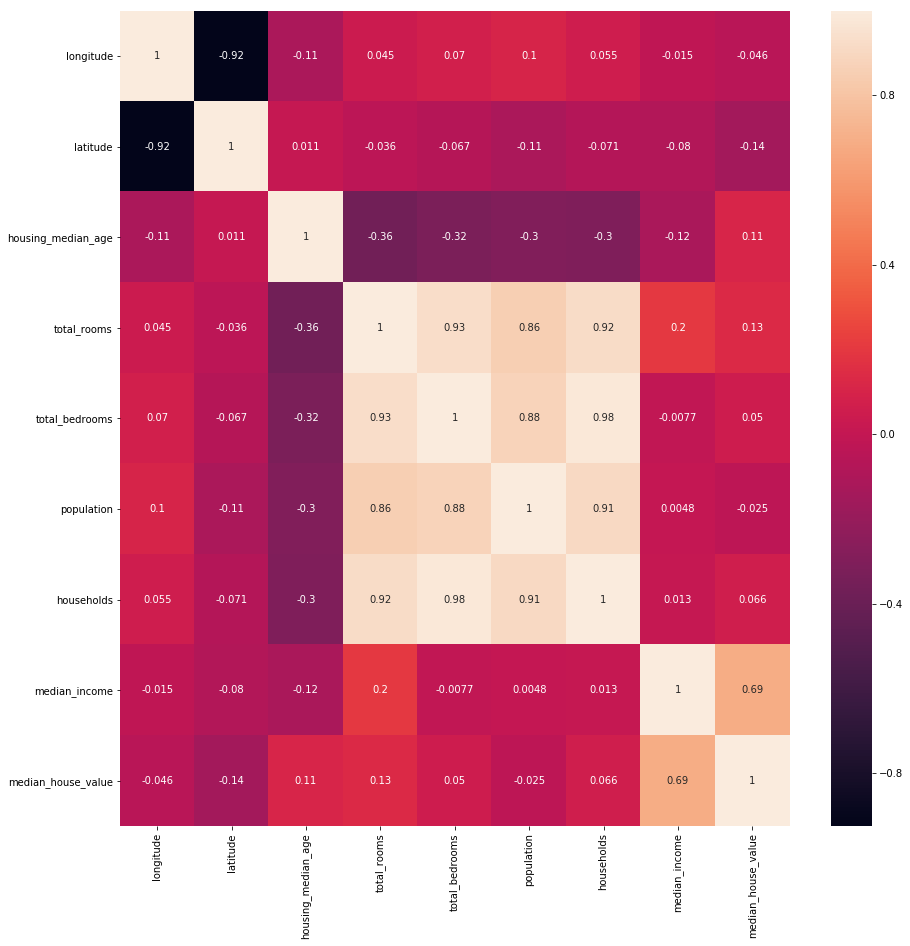

In [11]:
import seaborn as sns
corr = housing.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True)

Here we can see that correlation between median income feature and median house value is 0.69. So this is an important feature to predict median house value.

First random sampling approach

In [12]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

Next **Stratified sampling** approach. Since median income is important feature, so we would like to sampling the data in such a way so that it is representative of the whole population data.

create 5 strata to distribute the data based on 5 categories of median income value

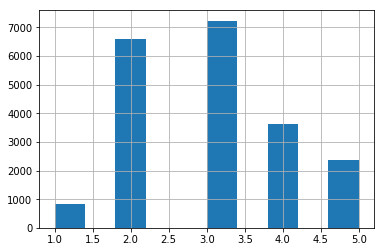

In [13]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0,1.5,3,4.5,6,np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

Stratified sampling using income category

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
sp = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in sp.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
strat_train_set.shape, strat_test_set.shape

((16512, 11), (4128, 11))

In [16]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts()/len(data)

In [17]:
train_set1, test_set1 = train_test_split(housing, test_size=0.2, random_state=42)
cat_proportions = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set1)
}).sort_index()
cat_proportions['Rand. %error'] = ((cat_proportions['Random']/cat_proportions['Overall'])*100)-100
cat_proportions['Strat. %error'] = ((cat_proportions['Stratified']/cat_proportions['Overall'])*100)-100

#### Sampling bias comparison of stratified vs purely random sampling

In [18]:
cat_proportions

,Overall,Random,Stratified,Rand. %error,Strat. %error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


## Discover and visualize the data to gain insights

Visualize geographical data

In [19]:
housing_data = strat_train_set.copy()

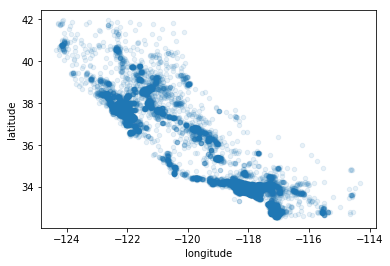

In [20]:
housing_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now let's look on the housing prices pattern based on district's population density

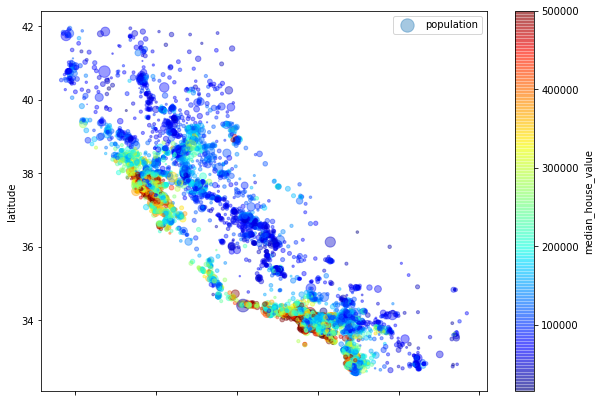

In [21]:
housing_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100,
                 label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'),
                 colorbar=True)
plt.legend()

It shows housing price very much related to housing prices. Housing price nearing coastal region is high, but for somes case is not also true. we can try to make a cluster but it will not be based on simple rules.

### Check correlation

In [22]:
corr_matrix = housing_data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687409
total_rooms           0.128806
housing_median_age    0.100988
households            0.060941
total_bedrooms        0.045505
population           -0.030445
longitude            -0.048702
latitude             -0.141245
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d200160>,
      dtype=object)

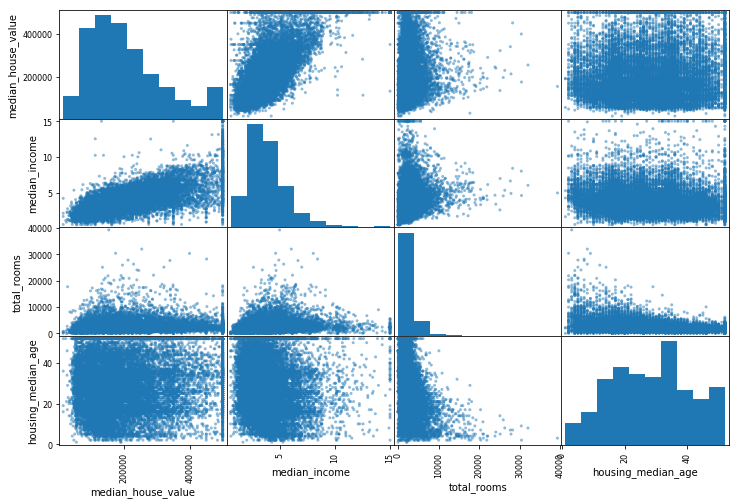

In [23]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing_data[attributes], figsize=(12,8))

The most promising attribute to median house value is median_income as per above scatter matrix

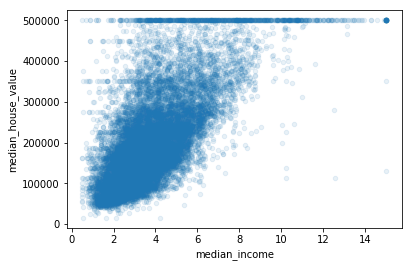

In [24]:
housing_data.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

As per above scatter plot it is visible that correlation bewtween median_income ans median_house_value is strong and has upward trend. And there are few horizontal lines visible which as because of capped value. So before feeding this data into a machine learning algorithm we must try to clean those data.

### Experimenting with attribute combination

In [25]:
housing_data['rooms_per_household'] = housing_data['total_rooms']/housing_data['households']
housing_data['bedrooms_per_room'] = housing_data['total_bedrooms']/housing_data['total_rooms']
housing_data['population_per_household'] = housing_data['population']/housing_data['households']

In [26]:
corr_matrix = housing_data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687409
rooms_per_household         0.144303
total_rooms                 0.128806
housing_median_age          0.100988
households                  0.060941
total_bedrooms              0.045505
population_per_household   -0.019790
population                 -0.030445
longitude                  -0.048702
latitude                   -0.141245
bedrooms_per_room          -0.254362
Name: median_house_value, dtype: float64

## Prepare data for Machine larning algorithms

In [27]:
housing  = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_num = housing.drop('ocean_proximity', axis=1)

In [28]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
8297,-118.14,33.76,50.0,2960.0,761.0,1179.0,718.0,3.5214,NEAR OCEAN,3
17602,-121.88,37.30,42.0,1867.0,398.0,927.0,389.0,4.3250,<1H OCEAN,3
5912,-118.44,34.29,32.0,1260.0,382.0,1434.0,342.0,2.0286,<1H OCEAN,2
5050,-118.33,34.02,11.0,1249.0,313.0,625.0,336.0,0.8702,<1H OCEAN,1
7161,-118.17,34.03,31.0,1014.0,252.0,1064.0,247.0,2.4167,<1H OCEAN,2


In [29]:
from sklearn.impute import SimpleImputer

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

In [31]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [32]:
class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedroorms_per_room=True):
        self.add_bedroorms_per_room = add_bedroorms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedroorms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [34]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [36]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [37]:
housing_prepared = full_pipeline.fit_transform(housing)

## Select and train a model

#### Linear regression

In [38]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [39]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68205.28490956777

Most houses are in a price range in between 120,000 and 265,000 so a typical prediction error of $68205 is not a good score

#### Decision tree regressor

In [40]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [41]:
housing_predictions = tree_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0

So, there is no error. Most likely model badly overfit the data. To make sure, we need to check with cross validation.

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [44]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std Deviation', scores.std())

In [45]:
display_scores(tree_rmse_scores)

Scores:  [67233.68290334 67316.74659546 68710.6200523  71618.93813775
 70035.85337271 68545.1936308  71401.74922689 67803.36136323
 71232.67423663 71403.52995338]
Mean:  69530.23494725054
Std Deviation 1712.4917443095742


Now, with decision tree regressor this score is worse than linear regression. Need to check the cross validation score with linear regression model just to be sure

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores:  [67417.03799812 69646.98653859 67556.99685719 68557.91433495
 67180.33245679 71734.30101656 69518.95490809 70318.2567814
 69247.59148079 66066.08790405]
Mean:  68724.44602765299
Std Deviation 1609.5529519881588


Now,it is confirmed that Decision tree model is overfitting badly, that it performs worse than linear regression.

#### Random forest regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [49]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18532.782714919136

In [48]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores:  [50198.71802881 47664.75808578 50148.96736088 49103.37782162
 49001.00790427 51333.46477858 51560.92060695 48522.81758526
 50773.67214419 48412.58868769]
Mean:  49672.029300402384
Std Deviation 1255.245644172182


Score is much better than linear regression and decision tree regressor model. However, error on training set (18532.782714919136) is much lower than in validation set (49672.029300402384). So it still overfits the training set. We will try hyperparameter tuning on random forest regressor, as it performs well than other two models.

## Hyperparameter tuning or regularization

In [54]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [55]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [56]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

## Evaluate the model on the test set

In [57]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [58]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49687.9457403713

#### Evaluate confidence interval

In [60]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors), loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([47469.36938746, 51811.60944955])

Finally, we can say using the model we can predict housing prices with error range as above (47469.36938746, 51811.60944955) with 95% confidence.